<a href="https://colab.research.google.com/github/moons54/IA_P8/blob/main/P08_Notebook02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### PROJET 08 PARTIE II
---
Participer à la conception d'une voiture Autonome

----

**Equipe 3 :  Segmentation des images**


---
Objectif : 
Concevoir un premier modèle de segmentation d'images


___
Plan d'action :

- Entrainer et deployer un modele de segmentation incluant 8 catégories principales
- Utilisation de l'API FLASK pour le deploiement


In [1]:
import os
import glob
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, UpSampling2D, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adadelta, Nadam
from tensorflow.keras.models import Model, load_model
# from tensorflow.keras.utils import multi_gpu_model, plot_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import tensorflow as tf
from tensorflow.keras.losses import binary_crossentropy
# from multiclassunet import Unet
import tqdm
import cv2
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import Callback
# from dilatednet import DilatedNet

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install -U segmentation-models

     |████████████████████████████████| 50 kB 8.3 MB/s 


In [ ]:
import segmentation_models as sm
sm.set_framework('tf.keras')

Segmentation Models: using `keras` framework.


In [ ]:
mymodel = tf.keras.models.load_model('/content/drive/MyDrive/OC_Aurelien_MIMOUNI/P08_Aurélien_MIMOUNI/best_model_fpn_fine_tune.h5',
                                        custom_objects={'focal_loss_plus_jaccard_loss': sm.losses.categorical_focal_jaccard_loss,
                                                        'iou_score': sm.metrics.iou_score})
mymodel.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, None, None,  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_34 (ZeroPadding2 (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d_34[0][0]          
____________________________________________________________________________________________

In [4]:
### Path source 
PATH_GTFINE_TRAIN = "/content/gtFine/train"
PATH_LEFTIMG8B_TRAIN = "/content/leftImg8bit/train"
PATH_GTFINE_TEST = "/content/gtFine/test"
PATH_LEFTIMG8B_TEST = "/content/leftImg8bit/test"
PATH_GTFINE_VAL = "/content/gtFine/val"
PATH_LEFTIMG8B_VAL = "/content/leftImg8bit/val"

## Path destination 
PATH_IMAGES_TRAIN = "/content/drive/MyDrive/data/train/images"
PATH_MASKS_TRAIN = "/content/drive/MyDrive/data/train/masks"
PATH_IMAGES_TEST = "/content/drive/MyDrive/data/test/images"
PATH_MASKS_TEST = "/content/drive/MyDrive/data/test/masks"
PATH_IMAGES_VAL = "/content/drive/MyDrive/data/val/images"
PATH_MASKS_VAL = "/content/drive/MyDrive/data/val/masks"

In [ ]:
test_image_dir = PATH_IMAGES_TRAIN+"/"
test_mask_dir = PATH_MASKS_TRAIN+"/"
test_image_list = [f for f in glob.iglob(os.path.join(test_image_dir, "*.png"))]
test_mask_list = [f for f in glob.iglob(os.path.join(test_mask_dir, "*.png"))]
test_image_list.sort()
test_mask_list.sort()
print(f'. . . . .Number of images: {len(test_image_list)}\n. . . . .Number of masks: {len(test_mask_list)}')


. . . . .Number of images: 2975
. . . . .Number of masks: 2975


In [ ]:
image_dir = PATH_IMAGES_TRAIN+"/"
mask_dir = PATH_MASKS_TRAIN+"/"


image_list = [f for f in glob.iglob(os.path.join(image_dir, "*.png"))]
mask_list = [f for f in glob.iglob(os.path.join(mask_dir, "*.png"))]
image_list.sort()
mask_list.sort()
print(f'. . . . .Number of images: {len(image_list)}\n. . . . .Number of masks: {len(mask_list)}')


. . . . .Number of images: 2975
. . . . .Number of masks: 2975


In [ ]:
val_image_dir = PATH_IMAGES_VAL+"/"
val_mask_dir = PATH_MASKS_VAL+"/"
val_image_list = [f for f in glob.iglob(os.path.join(val_image_dir, "*.png"))]
val_mask_list = [f for f in glob.iglob(os.path.join(val_mask_dir, "*.png"))]
val_image_list.sort()
val_mask_list.sort()
print(f'. . . . .Number of images: {len(val_image_list)}\n. . . . .Number of masks: {len(val_mask_list)}')

. . . . .Number of images: 500
. . . . .Number of masks: 500


In [ ]:
from sklearn.model_selection import train_test_split


In [ ]:
Image_list_train, Image_list_test, mask_list_train, mask_list_test = train_test_split(test_image_list,test_mask_list, test_size=0.2, random_state=101)

In [ ]:
def read_png(img):
    img = tf.io.read_file(img)
    img = tf.image.decode_png(img, channels=3)
    return img
    
def read_png_label(img):
    img = tf.io.read_file(img)
    img = tf.image.decode_png(img, channels=1)
    return img

In [ ]:
def rand_crop(img, label):
    concat_img = tf.concat([img, label], axis=-1)
    concat_img = tf.image.resize(concat_img, [280, 560],
                                 method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    crop_img = tf.image.random_crop(concat_img, [256, 256, 4])

    return crop_img[:, :, :3], crop_img[:, :, 3:]


def norm(img, label):
    img = tf.cast(img, tf.float32)/127.5-1
    label = tf.cast(label, tf.int32)

In [ ]:
def load_img_train(img, label):
    img = read_png(img)
    label = read_png_label(label)
    
    img, label = rand_crop(img, label)
    
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_left_right(img)
        label = tf.image.flip_left_right(label)
    
    return norm(img, label)


def load_img_val(img, label):
    img = read_png(img)
    label = read_png_label(label)
    
    img = tf.image.resize(img, [256, 256])
    label = tf.image.resize(label, [256, 256])

    return norm(img, label)

def load_img_test(img, label):
    img = read_png(img)
    label = read_png_label(label)
    
    img = tf.image.resize(img, [256, 256])
    label = tf.image.resize(label, [256, 256])

    return norm(img, label)

In [ ]:

def norm(img, label):
    img = tf.cast(img, tf.float32)/127.5-1
    label = tf.cast(label, tf.int32)

    return img, label

In [ ]:
BATCH_SIZE =  32#@param {type:"integer"}
EPOCHS = 20 #@param {type:"integer"}
IMG_HEIGHT, IMG_WIDTH = 256, 256
class_nb = 8
steps_per_epoch = 3000 // BATCH_SIZE
validation_steps = 1000 // BATCH_SIZE

In [ ]:
steps_per_epoch = 3000 // 32
validation_steps = 1000 // 32
auto = tf.data.experimental.AUTOTUNE


In [ ]:
#test_ds = test_ds.map(load_img_test, num_parallel_calls=auto)
train_ds = tf.data.Dataset.from_tensor_slices((Image_list_train, mask_list_train))
val_ds = tf.data.Dataset.from_tensor_slices((val_image_list, val_mask_list))
test_ds = tf.data.Dataset.from_tensor_slices((Image_list_test, mask_list_test))
print(next(iter(train_ds)))

(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/data/train/images/hamburg_000000_019373.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/data/train/masks/hamburg_000000_019373.png'>)


In [ ]:
steps_per_epoch = 3000 // BATCH_SIZE
validation_steps = 1000 // BATCH_SIZE
auto = tf.data.experimental.AUTOTUNE

train_ds = train_ds.map(load_img_train, num_parallel_calls=auto)
val_ds = val_ds.map(load_img_val, num_parallel_calls=auto)
test_ds = test_ds.map(load_img_test, num_parallel_calls=auto)
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

2380
500
595


In [ ]:
im = val_ds.take(1)

In [ ]:
im.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.string, name=None))

In [ ]:
#Modification pour transformation des données d'entrainement
input_dir = PATH_IMAGES_TEST + "/"
target_dir = PATH_MASKS_TEST + "/"
img_size = (160,160) #(160, 160)


input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".png")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 1525
/content/drive/MyDrive/data/test/images/berlin_000000_000019.png | /content/drive/MyDrive/data/test/masks/berlin_000000_000019.png
/content/drive/MyDrive/data/test/images/berlin_000001_000019.png | /content/drive/MyDrive/data/test/masks/berlin_000001_000019.png
/content/drive/MyDrive/data/test/images/berlin_000002_000019.png | /content/drive/MyDrive/data/test/masks/berlin_000002_000019.png
/content/drive/MyDrive/data/test/images/berlin_000003_000019.png | /content/drive/MyDrive/data/test/masks/berlin_000003_000019.png
/content/drive/MyDrive/data/test/images/berlin_000004_000019.png | /content/drive/MyDrive/data/test/masks/berlin_000004_000019.png
/content/drive/MyDrive/data/test/images/berlin_000005_000019.png | /content/drive/MyDrive/data/test/masks/berlin_000005_000019.png
/content/drive/MyDrive/data/test/images/berlin_000006_000019.png | /content/drive/MyDrive/data/test/masks/berlin_000006_000019.png
/content/drive/MyDrive/data/test/images/berlin_000007_00001

In [ ]:
#Modification pour transformation des données d'entrainement
input_dir = PATH_IMAGES_TRAIN + "/"
target_dir = PATH_MASKS_TRAIN + "/"
img_size = (160,160) #(160, 160)


input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".png")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 2975
/content/drive/MyDrive/OC_Aurelien_MIMOUNI/P08_Aurélien_MIMOUNI/data/images/train/aachen_000000_000019.png | /content/drive/MyDrive/OC_Aurelien_MIMOUNI/P08_Aurélien_MIMOUNI/data/masks/train/aachen_000000_000019.png
/content/drive/MyDrive/OC_Aurelien_MIMOUNI/P08_Aurélien_MIMOUNI/data/images/train/aachen_000001_000019.png | /content/drive/MyDrive/OC_Aurelien_MIMOUNI/P08_Aurélien_MIMOUNI/data/masks/train/aachen_000001_000019.png
/content/drive/MyDrive/OC_Aurelien_MIMOUNI/P08_Aurélien_MIMOUNI/data/images/train/aachen_000002_000019.png | /content/drive/MyDrive/OC_Aurelien_MIMOUNI/P08_Aurélien_MIMOUNI/data/masks/train/aachen_000002_000019.png
/content/drive/MyDrive/OC_Aurelien_MIMOUNI/P08_Aurélien_MIMOUNI/data/images/train/aachen_000003_000019.png | /content/drive/MyDrive/OC_Aurelien_MIMOUNI/P08_Aurélien_MIMOUNI/data/masks/train/aachen_000003_000019.png
/content/drive/MyDrive/OC_Aurelien_MIMOUNI/P08_Aurélien_MIMOUNI/data/images/train/aachen_000004_000019.png 

In [ ]:
#Modification pour transformation des données d'entrainement
input_dir = PATH_IMAGES_VAL + "/"
target_dir = PATH_MASKS_VAL + "/"
img_size = (160,160) #(160, 160)


input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".png")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 500
/content/drive/MyDrive/OC_Aurelien_MIMOUNI/P08_Aurélien_MIMOUNI/data/images/val/frankfurt_000000_000294.png | /content/drive/MyDrive/OC_Aurelien_MIMOUNI/P08_Aurélien_MIMOUNI/data/masks/val/frankfurt_000000_000294.png
/content/drive/MyDrive/OC_Aurelien_MIMOUNI/P08_Aurélien_MIMOUNI/data/images/val/frankfurt_000000_000576.png | /content/drive/MyDrive/OC_Aurelien_MIMOUNI/P08_Aurélien_MIMOUNI/data/masks/val/frankfurt_000000_000576.png
/content/drive/MyDrive/OC_Aurelien_MIMOUNI/P08_Aurélien_MIMOUNI/data/images/val/frankfurt_000000_001016.png | /content/drive/MyDrive/OC_Aurelien_MIMOUNI/P08_Aurélien_MIMOUNI/data/masks/val/frankfurt_000000_001016.png
/content/drive/MyDrive/OC_Aurelien_MIMOUNI/P08_Aurélien_MIMOUNI/data/images/val/frankfurt_000000_001236.png | /content/drive/MyDrive/OC_Aurelien_MIMOUNI/P08_Aurélien_MIMOUNI/data/masks/val/frankfurt_000000_001236.png
/content/drive/MyDrive/OC_Aurelien_MIMOUNI/P08_Aurélien_MIMOUNI/data/images/val/frankfurt_000000_001

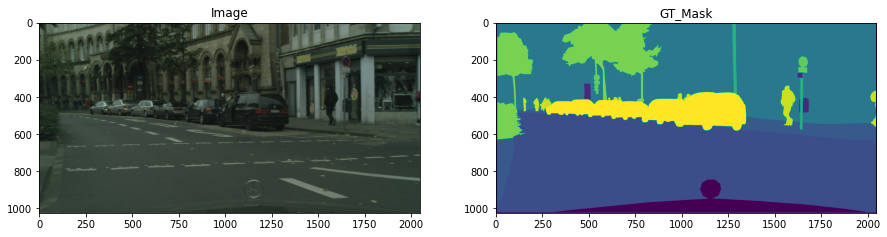

In [ ]:
#### Vision sur l'echantillon train
from tensorflow.python.keras.preprocessing import image

i = 100
test_image = image.img_to_array(image.load_img(f'{input_img_paths[i]}'))/255.
test_mask = image.img_to_array(image.load_img(f'{target_img_paths[i]}', color_mode="grayscale"))
test_mask = np.squeeze(test_mask)
batch_size = 32
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 2, 1)
ax.set_title('Image')
ax.imshow(test_image)

ax1 = fig.add_subplot(1, 2, 2)
ax1.set_title('GT_Mask')
ax1.imshow(test_mask)

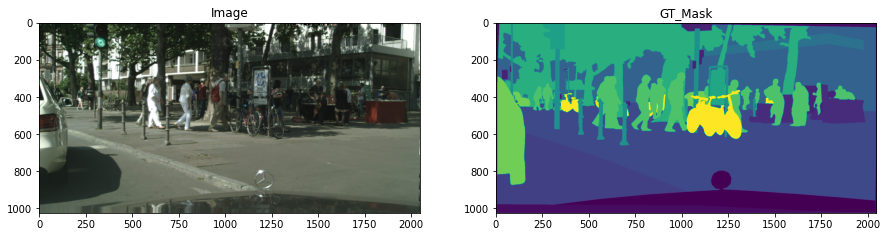

In [ ]:
#### Vision sur l'echantillon val
from tensorflow.python.keras.preprocessing import image

i = 100
test_image = image.img_to_array(image.load_img(f'{input_img_paths[i]}'))/255.
test_mask = image.img_to_array(image.load_img(f'{target_img_paths[i]}', color_mode="grayscale"))
test_mask = np.squeeze(test_mask)
batch_size = 32
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 2, 1)
ax.set_title('Image')
ax.imshow(test_image)

ax1 = fig.add_subplot(1, 2, 2)
ax1.set_title('GT_Mask')
ax1.imshow(test_mask)

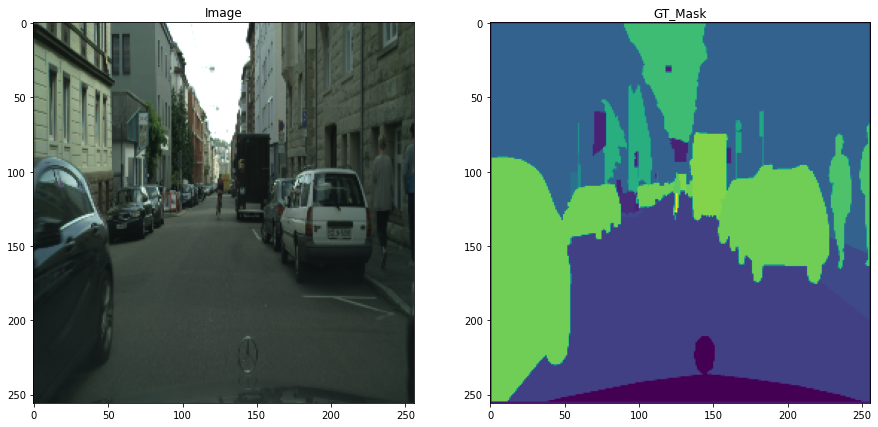

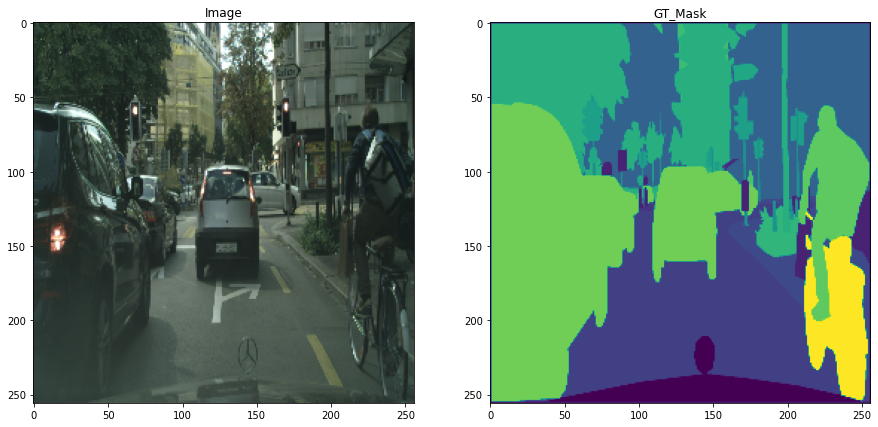

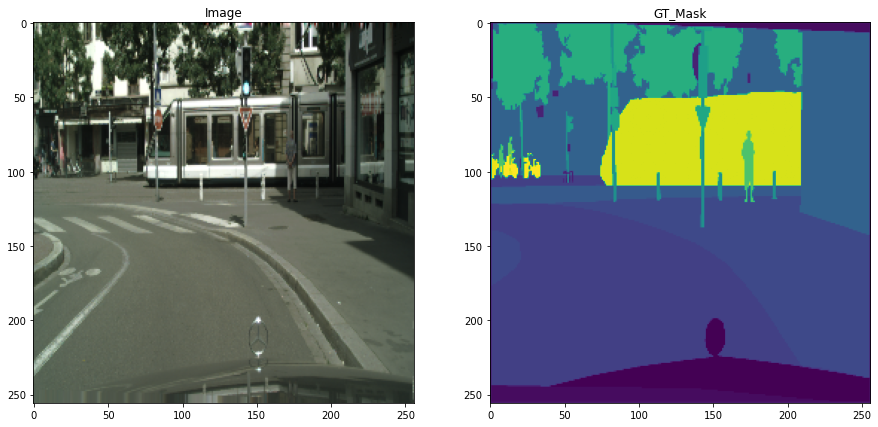

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
i = 100
for img, label in test_ds.take(3):
    
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(1, 2, 1)
    ax.set_title('Image')
    ax.imshow((img + 1)/2)

    ax1 = fig.add_subplot(1, 2, 2)
    ax1.set_title('GT_Mask')
    ax1.imshow(np.squeeze(label))

In [ ]:
image_list_train = []
mask_list_train = []
for img, label in train_ds:
    image_list_train.append(img)
    mask_list_train.append(label)
print(f'. . . . .Number of train images: {len(image_list_train)}\n. . . . .Number of train masks: {len(mask_list_train)}')

. . . . .Number of train images: 2380
. . . . .Number of train masks: 2380


In [ ]:
image_list_val = []
mask_list_val = []
for img, label in val_ds:
    image_list_val.append(img)
    mask_list_val.append(label)
print(f'. . . . .Number of val images: {len(image_list_val)}\n. . . . .Number of val masks: {len(mask_list_val)}')

. . . . .Number of val images: 500
. . . . .Number of val masks: 500


In [ ]:
image_list_test = []
mask_list_test = []
for img, label in test_ds:
    image_list_test.append(img)
    mask_list_test.append(label)
print(f'. . . . .Number of val images: {len(image_list_test)}\n. . . . .Number of val masks: {len(mask_list_test)}')

. . . . .Number of val images: 595
. . . . .Number of val masks: 595


In [ ]:
 cats = {'void': [0, 1, 2, 3, 4, 5, 6],
          'flat': [7, 8, 9, 10],
          'construction': [11, 12, 13, 14, 15, 16],
          'object': [17, 18, 19, 20],
          'nature': [21, 22],
          'sky': [23],
          'human': [24, 25],
          'vehicle': [26, 27, 28, 29, 30, 31, 32, 33, -1]}

    

In [ ]:
class DataGenerator_train(Sequence):


    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))


    def __getitem__(self, idx):

        idx = np.random.randint(0, len(self.x), batch_size)
        batch_x, batch_y = [], []
        drawn = 0
        for i in idx:
            _image = image_list_train[i]
            img = mask_list_train[i]
            labels = np.unique(img)            
            if len(labels) < 3:
                idx = np.random.randint(0, len(self.x), batch_size-drawn)
                continue
            img = np.squeeze(img)
            mask = np.zeros((img.shape[0], img.shape[1], 8))
            for i in range(-1, 34):
                if i in cats['void']:
                    mask[:,:,0] = np.logical_or(mask[:,:,0],(img==i))
                elif i in cats['flat']:
                    mask[:,:,1] = np.logical_or(mask[:,:,1],(img==i))
                elif i in cats['construction']:
                    mask[:,:,2] = np.logical_or(mask[:,:,2],(img==i))
                elif i in cats['object']:
                    mask[:,:,3] = np.logical_or(mask[:,:,3],(img==i))
                elif i in cats['nature']:
                    mask[:,:,4] = np.logical_or(mask[:,:,4],(img==i))
                elif i in cats['sky']:
                    mask[:,:,5] = np.logical_or(mask[:,:,5],(img==i))
                elif i in cats['human']:
                    mask[:,:,6] = np.logical_or(mask[:,:,6],(img==i))
                elif i in cats['vehicle']:
                    mask[:,:,7] = np.logical_or(mask[:,:,7],(img==i))

            mask = np.resize(mask,(IMG_HEIGHT,IMG_WIDTH, 8))
            batch_y.append(mask)
            batch_x.append(_image)
            drawn += 1
        return np.array(batch_x), np.array(batch_y)

class DataGenerator_val(Sequence):


    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))


    def __getitem__(self, idx):

        idx = np.random.randint(0, len(self.x), batch_size)
        batch_x, batch_y = [], []
        drawn = 0
        for i in idx:
            _image = image_list_val[i]
            img = mask_list_val[i]
            labels = np.unique(img)            
            if len(labels) < 3:
                idx = np.random.randint(0, len(self.x), batch_size-drawn)
                continue
            img = np.squeeze(img)
            mask = np.zeros((img.shape[0], img.shape[1], 8))
            for i in range(-1, 34):
                if i in cats['void']:
                    mask[:,:,0] = np.logical_or(mask[:,:,0],(img==i))
                elif i in cats['flat']:
                    mask[:,:,1] = np.logical_or(mask[:,:,1],(img==i))
                elif i in cats['construction']:
                    mask[:,:,2] = np.logical_or(mask[:,:,2],(img==i))
                elif i in cats['object']:
                    mask[:,:,3] = np.logical_or(mask[:,:,3],(img==i))
                elif i in cats['nature']:
                    mask[:,:,4] = np.logical_or(mask[:,:,4],(img==i))
                elif i in cats['sky']:
                    mask[:,:,5] = np.logical_or(mask[:,:,5],(img==i))
                elif i in cats['human']:
                    mask[:,:,6] = np.logical_or(mask[:,:,6],(img==i))
                elif i in cats['vehicle']:
                    mask[:,:,7] = np.logical_or(mask[:,:,7],(img==i))

            mask = np.resize(mask,(IMG_HEIGHT,IMG_WIDTH, 8))
            batch_y.append(mask)
            batch_x.append(_image)
            drawn += 1
        return np.array(batch_x), np.array(batch_y)


class DataGenerator_test(Sequence):


    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))


    def __getitem__(self, idx):

        idx = np.random.randint(0, len(self.x), batch_size)
        batch_x, batch_y = [], []
        drawn = 0
        for i in idx:
            _image = image_list_test[i]
            img = mask_list_test[i]
            labels = np.unique(img)            
            if len(labels) < 3:
                idx = np.random.randint(0, len(self.x), batch_size-drawn)
                continue
            img = np.squeeze(img)
            mask = np.zeros((img.shape[0], img.shape[1], 8))
            for i in range(-1, 34):
                if i in cats['void']:
                    mask[:,:,0] = np.logical_or(mask[:,:,0],(img==i))
                elif i in cats['flat']:
                    mask[:,:,1] = np.logical_or(mask[:,:,1],(img==i))
                elif i in cats['construction']:
                    mask[:,:,2] = np.logical_or(mask[:,:,2],(img==i))
                elif i in cats['object']:
                    mask[:,:,3] = np.logical_or(mask[:,:,3],(img==i))
                elif i in cats['nature']:
                    mask[:,:,4] = np.logical_or(mask[:,:,4],(img==i))
                elif i in cats['sky']:
                    mask[:,:,5] = np.logical_or(mask[:,:,5],(img==i))
                elif i in cats['human']:
                    mask[:,:,6] = np.logical_or(mask[:,:,6],(img==i))
                elif i in cats['vehicle']:
                    mask[:,:,7] = np.logical_or(mask[:,:,7],(img==i))

            mask = np.resize(mask,(IMG_HEIGHT,IMG_WIDTH, 8))
            batch_y.append(mask)
            batch_x.append(_image)
            drawn += 1
        return np.array(batch_x), np.array(batch_y)


train_generator = DataGenerator_train(image_list_train, mask_list_train, 32)
validation_generator = DataGenerator_val(image_list_val, mask_list_val, 1)
test_generator = DataGenerator_test(image_list_test, mask_list_test, 1)

In [ ]:
batch_size = 32

In [ ]:
es = EarlyStopping(mode='max', monitor='val_iou_score', patience=15, verbose=1) 
callbacks = [es]

In [ ]:

# model.fit(x, y, epochs=100)
hyst_best_ft_fpn_aug = mymodel.fit(train_generator, 
                    batch_size = 32, 
                    verbose=1, 
                    epochs=2, 
                    validation_data= validation_generator, 
                    # steps_per_epoch=25,
                    # validation_steps=25,
                    shuffle=True,
                    callbacks=callbacks)

Epoch 1/2
75/75 [==============================] - 403s 5s/step - loss: 0.3831 - iou_score: 0.6358 - accuracy: 0.8812 - val_loss: 1.0667 - val_iou_score: 0.0872 - val_accuracy: 0.2620
Epoch 2/2
75/75 [==============================] - 369s 5s/step - loss: 0.3460 - iou_score: 0.6711 - accuracy: 0.8947 - val_loss: 1.1597 - val_iou_score: 0.0767 - val_accuracy: 0.2600


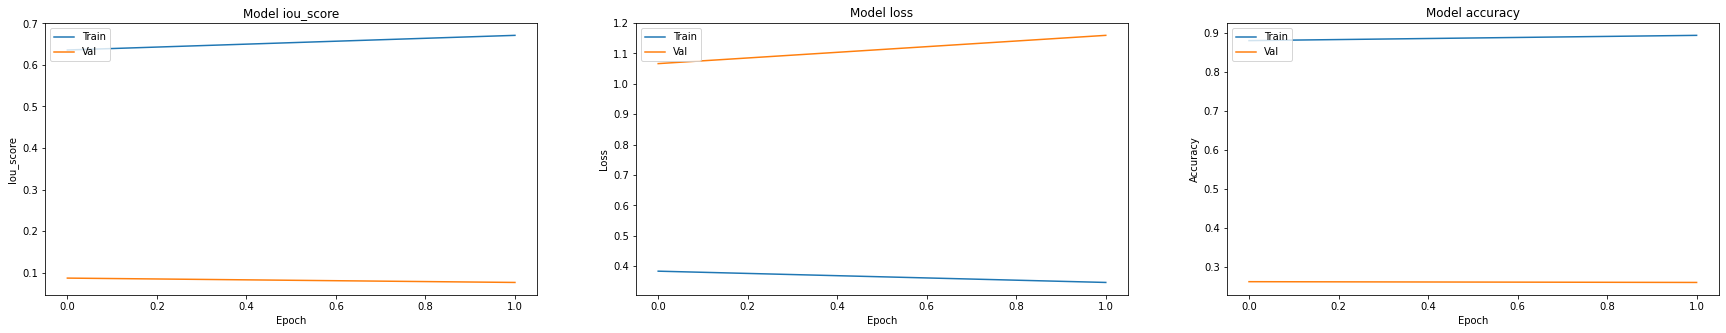

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(131)
plt.plot(hyst_best_ft_fpn_aug.history['iou_score'])
plt.plot(hyst_best_ft_fpn_aug.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('Iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(132)
plt.plot(hyst_best_ft_fpn_aug.history['loss'])
plt.plot(hyst_best_ft_fpn_aug.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation accuracy values
plt.subplot(133)
plt.plot(hyst_best_ft_fpn_aug.history['accuracy'])
plt.plot(hyst_best_ft_fpn_aug.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
scores = mymodel.evaluate(test_generator)
metrics=[sm.metrics.IOUScore, sm.metrics.FScore]
print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
  try :
    print("mean {}: {:.5}".format(metric.__name__, value))
  except AttributeError:
    print("mean {}: {:.5}".format(metric, value))
    continue

595/595 [==============================] - 353s 593ms/step - loss: 1.1536 - iou_score: 0.0797 - accuracy: 0.2628
Loss: 1.1536
mean IOUScore: 0.079712
mean FScore: 0.26278


In [1]:
!pip install azureml-dataset-runtime --upgrade

In [2]:
!pip install azureml.core

In [3]:
import pickle
import matplotlib.pyplot as plt
import azureml
from azureml.core import Experiment, Datastore, Dataset, Environment, Workspace, Run 
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException
from azureml.core.webservice import AciWebservice, Webservice
from azureml.core.model import InferenceConfig, Model
%matplotlib inline

In [4]:
ws = Workspace.from_config("/content/drive/MyDrive/data/config.json")

In [6]:
datastore = ws.get_default_datastore()


In [9]:
datastore = ws.get_default_datastore()

# upload the data to the datastore
datastore.upload(src_dir='/content/drive/MyDrive/data/train/images/',
                 target_path='/data/train/images',
                 overwrite=False,
                 show_progress=True)

Uploading an estimated of 2975 files
Target already exists. Skipping upload for data/train/images/weimar_000100_000019.png
Target already exists. Skipping upload for data/train/images/weimar_000076_000019.png
Target already exists. Skipping upload for data/train/images/weimar_000026_000019.png
Target already exists. Skipping upload for data/train/images/weimar_000116_000019.png
Target already exists. Skipping upload for data/train/images/weimar_000001_000019.png
Target already exists. Skipping upload for data/train/images/weimar_000027_000019.png
Target already exists. Skipping upload for data/train/images/weimar_000024_000019.png
Target already exists. Skipping upload for data/train/images/weimar_000120_000019.png
Target already exists. Skipping upload for data/train/images/weimar_000017_000019.png
Target already exists. Skipping upload for data/train/images/weimar_000082_000019.png
Target already exists. Skipping upload for data/train/images/weimar_000048_000019.png
Target already ex

$AZUREML_DATAREFERENCE_246b640c3ccd44cabf54948698b3d699

In [10]:
# upload the data to the datastore
datastore.upload(src_dir='/content/drive/MyDrive/data/train/masks/',
                 target_path='/data/train/masks',
                 overwrite=False,
                 show_progress=True)

Uploading an estimated of 2975 files
Target already exists. Skipping upload for data/train/masks/weimar_000004_000019.png
Target already exists. Skipping upload for data/train/masks/weimar_000053_000019.png
Target already exists. Skipping upload for data/train/masks/weimar_000048_000019.png
Target already exists. Skipping upload for data/train/masks/weimar_000089_000019.png
Target already exists. Skipping upload for data/train/masks/weimar_000002_000019.png
Target already exists. Skipping upload for data/train/masks/weimar_000031_000019.png
Target already exists. Skipping upload for data/train/masks/weimar_000087_000019.png
Target already exists. Skipping upload for data/train/masks/weimar_000046_000019.png
Target already exists. Skipping upload for data/train/masks/weimar_000109_000019.png
Target already exists. Skipping upload for data/train/masks/weimar_000094_000019.png
Target already exists. Skipping upload for data/train/masks/weimar_000027_000019.png
Target already exists. Skipp

$AZUREML_DATAREFERENCE_103f33c227464df8a969c18f8ea1fe17

In [ ]:
# upload the data to the datastore
datastore.upload(src_dir='/content/drive/MyDrive/data/val/images/',
                 target_path='/data/val/images',
                 overwrite=False,
                 show_progress=True)

In [ ]:
# upload the data to the datastore
datastore = ws.get_default_datastore()
datastore.upload(src_dir='/content/drive/MyDrive/data/val/masks/',
                 target_path='/data/val/masks',
                 overwrite=False,
                 show_progress=True)

In [7]:
# val masks dataset
val__masks_file_ds = Dataset.File.from_files(path=(datastore, 'data/val/masks/*.png'))
val__masks_file_ds = val__masks_file_ds.register(workspace=ws, name='my_val_masks')

In [ ]:
datastore = ws.get_default_datastore()
# upload the data to the datastore
datastore.upload(src_dir='/content/drive/MyDrive/data/test/images/',
                 target_path='/data/test/images',
                 overwrite=False,
                 show_progress=True)

In [ ]:
# upload the data to the datastore
datastore.upload(src_dir='/content/drive/MyDrive/data/test/masks/',
                 target_path='/data/test/masks',
                 overwrite=False,
                 show_progress=True)

In [ ]:
az_model = tf.keras.models.load_model('/content/drive/MyDrive/OC_Aurelien_MIMOUNI/P08_Aurélien_MIMOUNI/best_model_fpn_fine_tune.h5',compile=True, custom_objects={'focal_loss': sm.losses.categorical_focal_jaccard_loss,
                                                                                                                                 'iou_score': sm.metrics.IOUScore,
                                                                                                                                 'f1-score': sm.metrics.FScore})
az_model.summary()

ValueError: ignored

In [ ]:
az_model = tf.keras.models.load_model('/content/drive/MyDrive/OC_Aurelien_MIMOUNI/P08_Aurélien_MIMOUNI/best_model_fpn_fine_tune.h5',compile=True,
                                        custom_objects={'focal_loss_plus_jaccard_loss': sm.losses.categorical_focal_jaccard_loss,
                                                        'iou_score': sm.metrics.iou_score,
                                                        'f1-score':sm.metrics.FScore})
az_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, None, None,  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_34 (ZeroPadding2 (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d_34[0][0]          
____________________________________________________________________________________________

In [ ]:
%%time
history_az_model = az_model.fit(train_generator,
                                batch_size = 20, 
                                verbose=1,
                                epochs=2,
                                validation_data= validation_generator,
                                shuffle=True)

Epoch 1/2
75/75 [==============================] - 364s 5s/step - loss: 0.3760 - iou_score: 0.6423 - accuracy: 0.8853 - val_loss: 1.0505 - val_iou_score: 0.0697 - val_accuracy: 0.2530
Epoch 2/2
75/75 [==============================] - 342s 5s/step - loss: 0.3439 - iou_score: 0.6729 - accuracy: 0.8965 - val_loss: 1.1188 - val_iou_score: 0.0829 - val_accuracy: 0.2818
CPU times: user 13min 8s, sys: 14.2 s, total: 13min 23s
Wall time: 11min 47s


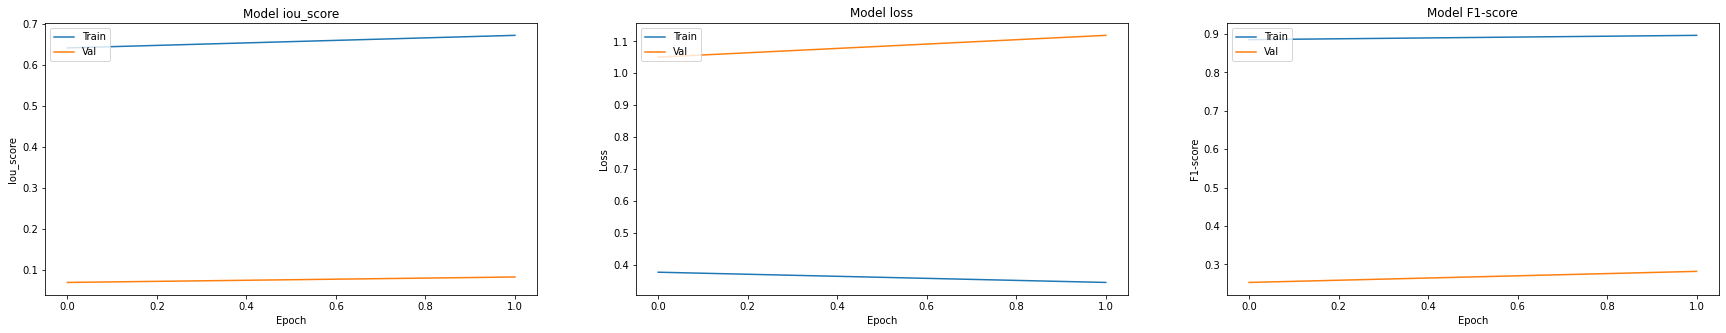

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(131)
plt.plot(history_az_model.history['iou_score'])
plt.plot(history_az_model.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('Iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(132)
plt.plot(history_az_model.history['loss'])
plt.plot(history_az_model.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation accuracy values
plt.subplot(133)
plt.plot(history_az_model.history['accuracy'])
plt.plot(history_az_model.history['val_accuracy'])
plt.title('Model F1-score')
plt.ylabel('F1-score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
history_az_model.history.items()

dict_items([('loss', [0.3759778141975403, 0.34388262033462524]), ('iou_score', [0.6422774791717529, 0.6729196906089783]), ('accuracy', [0.8853251338005066, 0.896499752998352]), ('val_loss', [1.050538420677185, 1.1188312768936157]), ('val_iou_score', [0.0696539431810379, 0.0829424113035202]), ('val_accuracy', [0.252968430519104, 0.28181523084640503])])

In [ ]:
import urllib.request
import json
import os

In [ ]:
import albumentations as alb

def round_clip_0_1(x, **kwargs):
    
    return x.round().clip(0, 1)


def get_training_augmentation():

    train_transform = [

        alb.HorizontalFlip(p=0.5),

        alb.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        alb.PadIfNeeded(min_height=IMG_HEIGHT, min_width=IMG_WIDTH, always_apply=True, border_mode=0),
        alb.RandomCrop(height=IMG_HEIGHT, width=IMG_WIDTH, always_apply=True),

        alb.GaussNoise(p=0.2),
        alb.Perspective(p=0.5),

        alb.OneOf(
            [
                alb.CLAHE(p=1),
                alb.RandomBrightnessContrast(p=1),
                alb.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        alb.OneOf(
            [
                alb.Sharpen(p=1),
                alb.Blur(blur_limit=3, p=1),
                alb.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        alb.OneOf(
            [
                alb.RandomBrightnessContrast(p=1),
                alb.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        alb.Lambda(mask=round_clip_0_1)
    ]
    return alb.Compose(train_transform)

In [ ]:
def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    val_transform = [
        alb.PadIfNeeded(min_height=IMG_HEIGHT, min_width=IMG_WIDTH)
    ]
    return alb.Compose(val_transform)


def get_preprocessing(preprocessing_fn):
    
    _transform = [
        alb.Lambda(image=preprocessing_fn),
    ]
    return alb.Compose(_transform)

In [ ]:
my_test_img = cv2.imread(test_image_list[0], cv2.IMREAD_UNCHANGED)
dim = (256, 256)
my_test_img = cv2.resize(my_test_img, dim, interpolation = cv2.INTER_AREA)/255.
trs = get_validation_augmentation() #training_augmentation()
sample = trs(image=my_test_img)
my_test_img = sample['image']
my_test_img = np.expand_dims(my_test_img, axis=0).tolist()

In [ ]:
input_data = json.dumps({"data": my_test_img})
input_data = bytes(input_data, encoding = 'utf8')

f = open('/content/drive/MyDrive/data/test/images/berlin_000000_000019.png', 'wb')
f.write(input_data)
f.close()

In [ ]:
f = open('/content/drive/MyDrive/data/test/images/berlin_000000_000019.png', 'rb')
new_data = f.read()
f.close()

In [ ]:
new_data

b'{"data": [[[[0.792156862745098, 0.807843137254902, 0.6862745098039216], [0.788235294117647, 0.807843137254902, 0.6823529411764706], [0.596078431372549, 0.6, 0.4823529411764706], [0.6392156862745098, 0.6470588235294118, 0.5568627450980392], [0.803921568627451, 0.8156862745098039, 0.6941176470588235], [0.807843137254902, 0.8235294117647058, 0.7098039215686275], [0.807843137254902, 0.8235294117647058, 0.7137254901960784], [0.807843137254902, 0.8274509803921568, 0.7176470588235294], [0.8117647058823529, 0.8274509803921568, 0.7058823529411765], [0.807843137254902, 0.8196078431372549, 0.7098039215686275], [0.803921568627451, 0.8196078431372549, 0.7098039215686275], [0.8, 0.8196078431372549, 0.7098039215686275], [0.807843137254902, 0.8196078431372549, 0.7058823529411765], [0.807843137254902, 0.8156862745098039, 0.7058823529411765], [0.803921568627451, 0.8196078431372549, 0.7019607843137254], [0.8117647058823529, 0.8196078431372549, 0.7058823529411765], [0.807843137254902, 0.8235294117647058

In [ ]:
url = 'http://105c6fc0-e575-424c-ac1b-ea3a218ab160.eastus.azurecontainer.io/score'
api_key = '' # Replace this with the API key for the web service
headers = {'Content-Type':'application/json'}#, 'Authorization':('Bearer '+ api_key)}

req = urllib.request.Request(url, new_data, headers)

try:
    response = urllib.request.urlopen(req)

    result = response.read()
    print(result)
except urllib.error.HTTPError as error:
    print("The request failed with status code: " + str(error.code))

    # Print the headers - they include the requert ID and the timestamp, which are useful for debugging the failure
    print(error.info())
    print(json.loads(error.read().decode("utf8", 'ignore')))


In [ ]:
pred = eval(result.decode("utf-8"))
pred =  json.loads(pred)
vis = np.array(pred["predict"][0])
visualize(res=vis[:,:,:3])

NameError: ignored